In [1]:
cd(expanduser("/project/GHIST-2025/bottleneck-challenge"))
Base.init_active_project()
pwd(), Base.active_project(), gethostname()

("/project/GHIST-2025/bottleneck-challenge", "/project/GHIST-2025/bottleneck-challenge/Project.toml", "folsomprisonblues.molgen.mpg.de")

In [2]:
using CSV
using DataFrames
using HistogramBinnings, StatsBase
using PyPlot
using HetDister, DemoPlots
using MariuxUtils, ProgressMeter, Distributed, Cached
using Serialization

In [3]:
df = CSV.read("GHIST_2025_bottleneck.final.vcf.gz", DataFrame, comment = "##", drop = [:INFO])
indvs = names(df)[10:end]
first(df, 5)

Row,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,FORMAT,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22
,Int64,Int64,Int64,String1,String3,String1,String7,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3,String3
1,1,83,0,A,T,.,PASS,GT,1|1,0|1,0|1,1|1,0|1,0|0,0|1,1|1,1|0,1|0,0|0,1|1,1|0,1|0,0|0,0|0,1|0,0|1,0|0,1|1,1|1,1|1
2,1,546,1,A,T,.,PASS,GT,0|0,0|0,1|0,0|0,0|0,0|1,1|0,0|0,0|1,0|1,1|1,0|0,0|0,0|0,0|1,0|1,0|1,1|0,1|0,0|0,0|0,0|0
3,1,824,2,A,C,.,PASS,GT,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,0|0
4,1,847,3,A,G,.,PASS,GT,0|0,0|0,1|0,0|0,0|0,0|1,0|0,0|0,0|1,0|1,1|1,0|0,0|0,0|0,0|1,0|1,0|1,0|0,0|0,0|0,0|0,0|0
5,1,981,4,T,A,.,PASS,GT,1|1,0|1,0|1,1|1,0|1,0|0,0|1,1|1,1|0,1|0,0|0,1|1,1|0,1|0,0|0,0|0,1|0,0|1,0|0,1|1,1|1,1|1


In [4]:
@assert all(df.POS[2:end] .!= df.POS[1:end-1])

In [65]:
function getsegments(df, indv1, indv2, allele1, allele2)
    pos = [0]
    for r in eachrow(df)
        a1 = allele1 == 1 ? r[indv1][1] : r[indv1][3]
        a2 = allele2 == 1 ? r[indv2][1] : r[indv2][3]
        @assert a1 != '.' && a1 != '|'
        @assert a2 != '.' && a2 != '|'
        if a1 != a2
            push!(pos, r.POS)
        end
    end
    push!(pos, 100_000_000)
    ils = pos[2:end] .- pos[1:end-1]
end

getsegments (generic function with 1 method)

In [63]:
function aggsegs(df; nsamples=22)
    segs = Int[]
    for i in 1:(2nsamples-1)
        for j in i+1:2nsamples
            indv1 = "sample_$((i+1)÷2)"
            indv2 = "sample_$((j+1)÷2)"
            a1 = isodd(i) ? 1 : 2
            a2 = isodd(j) ? 1 : 2
            @assert indv1 != indv2 || a1 != a2
            ils = getsegments(df, indv1, indv2, a1, a2)
            if length(ils) == 0
                @error "No segments for $indv1($a1) and $indv2($a2), skipping."
                continue
            end
            append!(segs, ils)
        end
    end
    segs
end

aggsegs (generic function with 1 method)

In [5]:
function makepairs(df; nsamples=22)
    histograms = []
    for i in 1:(2nsamples-1)
        for j in i+1:2nsamples
            indv1 = "sample_$((i+1)÷2)"
            indv2 = "sample_$((j+1)÷2)"
            a1 = isodd(i) ? 1 : 2
            a2 = isodd(j) ? 1 : 2
            @assert indv1 != indv2 || a1 != a2
            ils = getsegments(df, indv1, indv2, a1, a2)
            if length(ils) == 0
                @error "No segments for $indv1($a1) and $indv2($a2), skipping."
                continue
            end
            h = adapt_histogram(ils; nbins = 800)
            push!(histograms, h)
        end
    end
    histograms
end

makepairs (generic function with 1 method)

## aggregate

In [66]:
segments = aggsegs(df);

In [3]:
# serialize("aggregate-segments-final", segments);
segments = deserialize("aggregate-segments");

In [4]:
mu = 1.4e-8
rho = 1.5e-8
L = sum(segments)

94600000000

In [5]:
hagg = adapt_histogram(segments; nbins=1700, tailthr=2);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


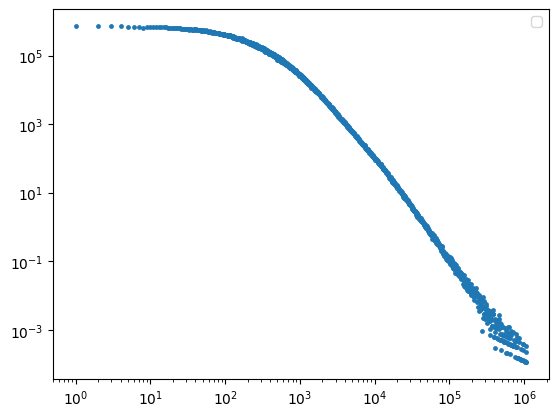

In [6]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

x, y = xy(hagg)
ax.scatter(x, y; s = 6)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

In [7]:
fop = FitOptions(L, mu, rho; maxnts=5, iterations=30000, time_limit=120, g_tol=1e-5)
naive = pre_fit!(fop, hagg, 6; require_convergence=false)

6-element Vector{FitResult}:
 Fit stationary (binned 1700) L-BFGS ● [9.0e+10, 35085.6] logL -170981.072 | evidence -171005.183
 Fit 2 epochs (binned 1700) L-BFGS ● [9.3e+10, 39476.8, 100821.1, 32717.7] logL -111721.483 | evidence -111768.625
 Fit 3 epochs (binned 1700) L-BFGS ● [9.5e+10, 45418.2, 183202.6, 34333.7, 11086.4, 26210.4] logL -92526.409 | evidence -92597.293
 Fit 4 epochs (binned 1700) L-BFGS ● [9.5e+10, 45021.8, 182593.9, 34229.0, 10.0, 149.9, 6067.5, 29769.4] logL -91760.453 | evidence -91857.056
 Fit 5 epochs (binned 1700) L-BFGS ● [9.5e+10, 43697.8, 150407.3, 33805.0, 2627.0, 100000000.0, 12245.1, 24591.2, 3045.0, 29959.3] logL -91470.815 | evidence -91570.297
 Fit 6 epochs (binned 1700) L-BFGS ● [9.5e+10, 10.0, 243021.7, 61007.6, 206766.2, 34073.2, 2184.1, 100000000.0, 10086.8, 23727.2, 3734.0, 29562.7] logL -91327.240 | evidence -91439.534

In [8]:
cutoff = 1e-5
o = findfirst(map(i->HetDister.fraction(mu,rho,i),1:30) .< cutoff)

18

In [10]:
job = (; hagg.edges, hagg.weights, L, mu, rho)

(edges = (LogEdgeVector{Int64}: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

In [ ]:
fem = FlexElasticManager(threads = 64, runtime = "3h", memory = "60G") # 144 min

FlexElasticManager: MIO-Sun-1240 active: 0

In [19]:
MariuxUtils.@everywhere fem begin

    using HetDister, StatsBase, Cached

    function fit(job)
        h = Histogram(job.edges)
        h.weights .= job.weights
        fop = FitOptions(job.L, job.mu, job.rho; order = 20, ndt = 1700, 
            maxnts=5, iterations=30000, time_limit=120, g_tol=1e-5
        )
        fit = demoinfer(h, 2:6, fop; iters = 30, corcut = 0)
        return fit
    end

end # everywhere

In [20]:
addprocs(fem, MXQ, 1)

FlexElasticManager: MIO-Sun-1240 active: 0  MXQgroup (3h): no active jobs

In [21]:
waituntilactive(fem)

FlexElasticManager: MIO-Sun-1240 active: 1  MXQgroup (3h): inq:0 run:1 fin:0

In [22]:
results = pmap(fit, [job]);

In [23]:
rmprocs(fem)

FlexElasticManager: MIO-Sun-1240 active: 0, terminated: 1  MXQgroup (3h): inq:0 run:1 fin:0

In [33]:
# serialize("fits-final", results[1])
final = deserialize("fits-final")

(fits = FitResult[Fit 2 epochs (binned 1700) L-BFGS ● [9.5e+10, 48208.2, 3438.1, 12027.0] logL -106096.998 | evidence -106147.948, Fit 3 epochs (binned 1700) L-BFGS ● [9.4e+10, 10.0, 470381.0, 48906.2, 3615.1, 12230.9] logL -97992.159 | evidence -98060.039, Fit 4 epochs (binned 1700) L-BFGS ● [9.5e+10, 43665.7, 140732.1, 51334.7, 25017.9, 42592.2, 2965.1, 11699.4] logL -87913.866 | evidence -88009.599, Fit 5 epochs (binned 1700) L-BFGS ● [9.5e+10, 44114.4, 142126.6, 51519.3, 10.0, 77.3, 10798.0, 72203.3, 3533.9, 11929.9] logL -87963.637 | evidence -88083.769], chains = Vector{Any}[[Fit 2 epochs (binned 1700) L-BFGS ● [9.5e+10, 45483.1, 3322.8, 18467.5] logL -130261.820 | evidence -130311.856, Fit 2 epochs (binned 1700) L-BFGS ● [9.5e+10, 46848.0, 4033.7, 16222.0] logL -88479.984 | evidence -88530.410, Fit 2 epochs (binned 1700) L-BFGS ● [9.5e+10, 47553.2, 4054.1, 14702.0] logL -90749.813 | evidence -90800.476, Fit 2 epochs (binned 1700) L-BFGS ● [9.5e+10, 47902.6, 3900.9, 13670.9] logL

In [35]:
final.fits

4-element Vector{FitResult}:
 Fit 2 epochs (binned 1700) L-BFGS ● [9.5e+10, 48208.2, 3438.1, 12027.0] logL -106096.998 | evidence -106147.948
 Fit 3 epochs (binned 1700) L-BFGS ● [9.4e+10, 10.0, 470381.0, 48906.2, 3615.1, 12230.9] logL -97992.159 | evidence -98060.039
 Fit 4 epochs (binned 1700) L-BFGS ● [9.5e+10, 43665.7, 140732.1, 51334.7, 25017.9, 42592.2, 2965.1, 11699.4] logL -87913.866 | evidence -88009.599
 Fit 5 epochs (binned 1700) L-BFGS ● [9.5e+10, 44114.4, 142126.6, 51519.3, 10.0, 77.3, 10798.0, 72203.3, 3533.9, 11929.9] logL -87963.637 | evidence -88083.769

In [24]:
results[1].fits

5-element Vector{FitResult}:
 Fit 2 epochs (binned 1700) L-BFGS ● [9.5e+10, 37954.3, 7899.6, 16875.2] logL -102651.089 | evidence -102701.706
 Fit 3 epochs (binned 1700) L-BFGS ● [9.5e+10, 31187.2, 201161.3, 38970.7, 8641.2, 16949.7] logL -93266.578 | evidence -93338.138
 Fit 4 epochs (binned 1700) L-BFGS ● [9.5e+10, 35151.4, 66413.4, 42382.0, 26236.3, 34799.1, 7350.6, 16644.3] logL -91971.240 | evidence -92065.211
 Fit 5 epochs (binned 1700) L-BFGS ● [9.5e+10, 36514.3, 19465.0, 100000000.0, 10.0, 14.8, 11383.2, 100000000.0, 8568.7, 16460.2] logL -92841.978 | evidence -92939.262
 Fit 6 epochs (binned 1700) L-BFGS ● [9.5e+10, 38004.6, 10.0, 60.6, 9159.1, 100000000.0, 10.0, 26.3, 2833.6, 100000000.0, 494.2, 9864.5] logL -106630.913 | evidence -106764.633

In [25]:
f = compare_models(results[1].fits)

LoadError: UndefVarError: `mono` not defined in `HetDister`
Suggestion: check for spelling errors or missing imports.

In [111]:
results[1].chains[2]

11-element Vector{Any}:
 Fit 3 epochs (binned 1327) L-BFGS ● [1.0e+08, 45288.3, 3932.0, 100000000.0, 5695.7, 18515.4] logL -4085.390 | evidence -4124.749
 Fit 3 epochs (binned 1327) L-BFGS ● [1.0e+08, 46772.5, 3046.9, 13530.1, 77.9, 99999999.9] logL -4042.584 | evidence -4076.535
 Fit 3 epochs (binned 1327) L-BFGS ● [1.0e+08, 47583.4, 9296.8, 40690.7, 2617.7, 12206.1] logL -4042.447 | evidence -4093.686
 Fit 3 epochs (binned 1327) L-BFGS ● [1.0e+08, 47965.1, 7520.2, 35321.8, 2231.1, 11266.9] logL -4046.903 | evidence -4098.777
 Fit 3 epochs (binned 1327) L-BFGS ● [1.0e+08, 48177.9, 7134.7, 32598.0, 2050.6, 10905.7] logL -4050.131 | evidence -4102.341
 Fit 3 epochs (binned 1327) L-BFGS ● [1.0e+08, 48277.2, 6631.2, 30210.6, 1929.4, 10848.9] logL -4053.298 | evidence -4105.673
 Fit 3 epochs (binned 1327) L-BFGS ● [1.0e+08, 48325.8, 6306.9, 28632.9, 1855.3, 10888.6] logL -4054.314 | evidence -4106.755
 Fit 3 epochs (binned 1327) L-BFGS ● [1.0e+08, 48346.5, 6022.1, 27259.0, 1796.9, 11004.5]

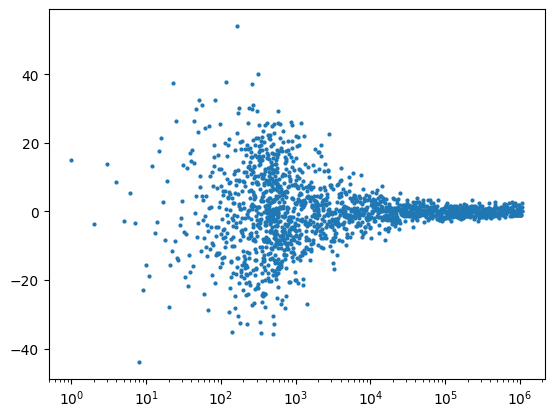

In [8]:
_, ax = subplots(1,1)
# resid = compute_residuals(hagg, mu, rho, get_para(naive[7]), order = 20, ndt = 1700, naive=true)
# wth = results[1].yth[3] .* diff(h.edges[1])
wth = HetDister.integral_ws(hagg.edges[1], mu, get_para(naive[6]))
resid = (hagg.weights .- wth) ./ sqrt.(wth)
x, y = xy(hagg)
scatter(x, resid; s=4)
xscale("log")
# ylim(-0.3,0.3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


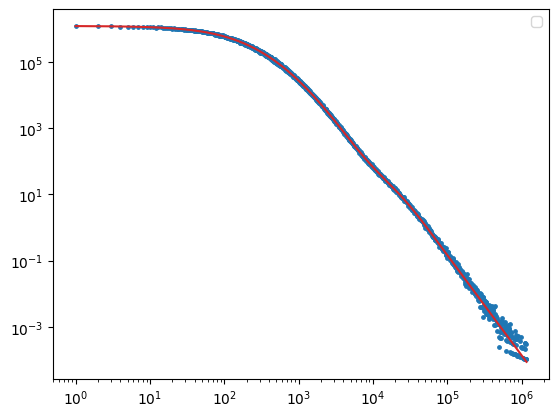

In [25]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

x, y = xy(hagg)
ax.scatter(x, y; s = 6)
ax.plot(x, results[1].yth[f.nepochs-1], color="tab:red")

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend();

In [36]:
para = get_para(final.fits[3])
para[end] / para[end-2], para[end-1]

(0.274683648011105, 2965.1010238687413)

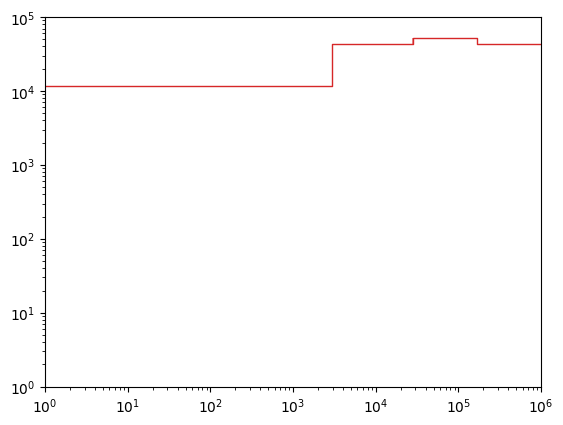

(1, 100000.0)

In [37]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

plot_demography(final.fits[3], ax; g = 1, rho)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1, 1e6)
ax.set_ylim(1, 1e5)

## all pairs

In [19]:
segments = getsegments(df, :sample_1, :sample_3, 2, 2);
h = adapt_histogram(segments; nbins = 800)

Histogram{Int64, 1, Tuple{LogEdgeVector{Int64}}}
edges:
  LogEdgeVector{Int64}: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 20

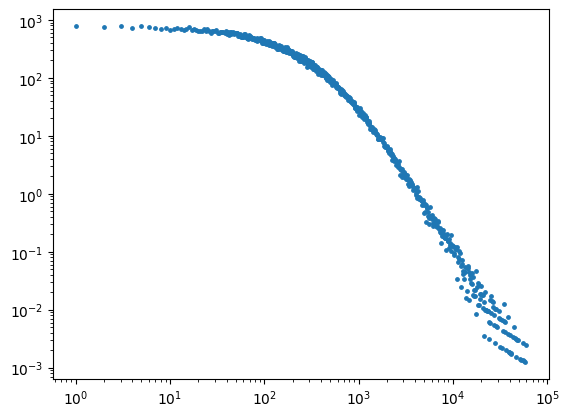

In [20]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

x, y = xy(h)
ax.scatter(x, y; s = 6)

ax.set_xscale("log")
ax.set_yscale("log")

In [6]:
histograms = makepairs(df);

In [4]:
# serialize("histograms", histograms)
histograms = deserialize("histograms");

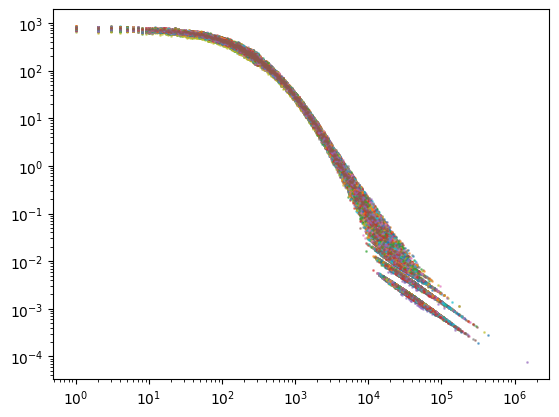

In [9]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

for h in histograms
    x, y = xy(h)
    ax.scatter(x, y; s = 1, alpha = 0.5)
end

ax.set_xscale("log")
ax.set_yscale("log")

In [5]:
mu = 1.4e-8
rho = 1.5e-8

1.5e-8

In [6]:
jobs = map(histograms) do h
    (; h.edges, h.weights, mu, rho, L = 100_000_000)
end;

In [7]:
cache = SQLiteCache("/project/GHIST-2025/bottleneck-challenge/pairs.cache")

SQLiteCache at /project/GHIST-2025/bottleneck-challenge/pairs.cache

In [8]:
length(jobs)

946

In [46]:
fem = FlexElasticManager(threads = 8, runtime = "3h", memory = "60G") # 31m

FlexElasticManager: HLO-Wed-1211 active: 0

In [47]:
MariuxUtils.@everywhere fem begin

    using HetDister, StatsBase, Cached

    function fit_pair(job)
        h = Histogram(job.edges)
        h.weights .= job.weights
        fop = FitOptions(job.L, job.mu, job.rho; order = 20, maxnts = 8)
        res = demoinfer(h, 2, fop; iters = 10, corcut = 0)
        opt = (;
            iterations = 600,
            allow_f_increases=true,
            time_limit = 7000,
            g_tol = 5e-8,
            show_warnings = false
        )
        fop.opt = HetDister.Optim.Options(;opt...)
        HetDister.setnaive!(fop, false)
        HetDister.setnepochs!(fop, 2)
        init = get_para(res.f)
        HetDister.setinit!(fop, init)
        mle = HetDister.fit_model_epochs!(fop, h)
        # yth = deepcopy(res.yth)
        final = get_para(mle)
        conv = mle.converged
        return (; 
            final,
            conv,
            res.chain,
            res.corrections,
            res.yth,
            res.deltas
        )
    end

end # everywhere

In [48]:
addprocs(fem, MXQ, 500)

FlexElasticManager: HLO-Wed-1211 active: 0  MXQgroup (3h): no active jobs

In [ ]:
waituntilactive(fem)

FlexElasticManager: HLO-Wed-1211 active: 404  MXQgroup (3h): inq:96 run:404 fin:0

Progress:  75%|███████▄  |  ETA: 0:28:51

In [74]:
@async results = pcmap(fit_pair, cache, jobs);

In [90]:
summary(cache)

"SQLiteCache at /project/GHIST-2025/bottleneck-challenge/pairs.cache: 925 items in memory, 924 items on disk, 60.430 MiB on disk"

In [94]:
fem

FlexElasticManager: HLO-Wed-1211 active: 0, terminated: 500  MXQgroup (3h): inq:0 run:0 fin:333 fail:167

In [92]:
rmprocs(fem)

FlexElasticManager: HLO-Wed-1211 active: 0, terminated: 500  MXQgroup (3h): inq:0 run:96 fin:318 fail:86

In [ ]:
Cached.loadall!(cache)
results = values(cache.loaded);

In [121]:
meanpara = zeros(Float64, 4)
count = 0
for res in results
    try
        if res.conv == true
            meanpara .+= res.final
            count += 1
        end
    catch
        if res.mle.converged == true
            meanpara .+= get_para(res.mle)
            count += 1
        end
    end
end
meanpara ./= count
count

872

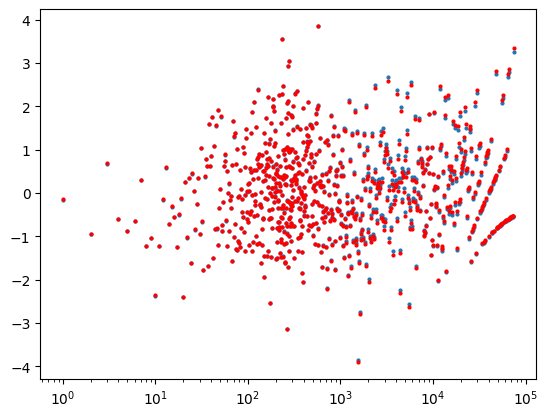

Worker 2 terminated.
Unhandled Task ERROR: EOFError: read end of file
Stacktrace:
 [1] (::Base.var"#wait_locked#unsafe_read##0")(s::Sockets.TCPSocket, buf::IOBuffer, nb::Int64)
   @ Base ./stream.jl:980
 [2] unsafe_read(s::Sockets.TCPSocket, p::Ptr{UInt8}, nb::UInt64)
   @ Base ./stream.jl:988
 [3] unsafe_read
   @ ./io.jl:890 [inlined]
 [4] unsafe_read(s::Sockets.TCPSocket, p::Base.RefValue{NTuple{4, Int64}}, n::Int64)
   @ Base ./io.jl:889
 [5] read!
   @ ./io.jl:894 [inlined]
 [6] deserialize_hdr_raw
   @ ~/.julia/juliaup/julia-1.12.1+0.x64.linux.gnu/share/julia/stdlib/v1.12/Distributed/src/messages.jl:167 [inlined]
 [7] message_handler_loop(r_stream::Sockets.TCPSocket, w_stream::Sockets.TCPSocket, incoming::Bool)
   @ Distributed ~/.julia/juliaup/julia-1.12.1+0.x64.linux.gnu/share/julia/stdlib/v1.12/Distributed/src/process_messages.jl:172
 [8] process_tcp_streams(r_stream::Sockets.TCPSocket, w_stream::Sockets.TCPSocket, incoming::Bool)
   @ Distributed ~/.julia/juliaup/julia-1.12.1

In [ ]:
_, ax = subplots(1,1)
for res in results
    wth = res.yth .* diff(histograms[1].edges[1])
    resid = (histograms[1].weights .- wth) ./ sqrt.(wth)
    # resid = compute_residuals(histograms[1], mu, rho, get_para(results[1].mle), order = 20)
    x, y = xy(histograms[1])
    scatter(x[1:end], resid[1:end]; s=4)
xscale("log")

In [122]:
meanpara[end] / meanpara[2], meanpara[end-1]

(0.45624968319126147, 8034.834238397046)

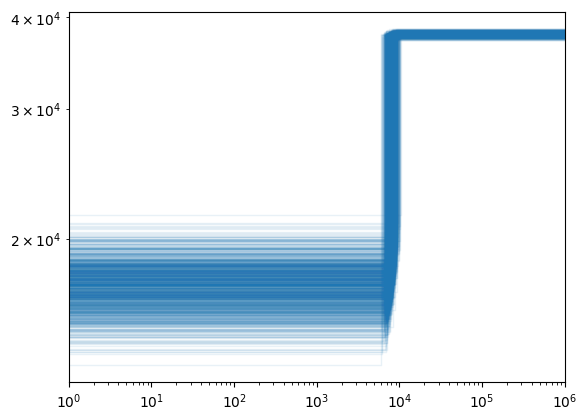

(1, 1.0e6)

In [105]:
fig = figure()
ax = fig.add_subplot(1, 1, 1)

# results = deserialize("results-pairs");

for res in results
    f = nothing
    try 
        f = res.final
    catch
        f = get_para(res.mle)
    end
    plot_demography(f, [1,1,1,1], ax; g = 1, rho, alpha = 0.1, alphapatch=0.00, color = "tab:blue")
end
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1, 1e6)

In [123]:
allts = Float64[]
for res in results
    try
        if res.conv == true
            push!(allts, res.final[end-1])
        end
    catch
        if res.mle.converged == true
            push!(allts, get_para(res.mle)[end-1])
        end
    end
end

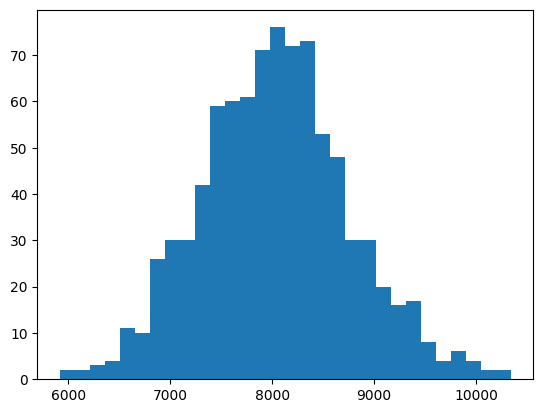

([2.0, 2.0, 3.0, 4.0, 11.0, 10.0, 26.0, 30.0, 30.0, 42.0  …  30.0, 20.0, 16.0, 17.0, 8.0, 4.0, 6.0, 4.0, 2.0, 2.0], [5919.685002556233, 6067.026101690875, 6214.367200825517, 6361.70829996016, 6509.049399094802, 6656.390498229444, 6803.731597364087, 6951.072696498729, 7098.413795633372, 7245.754894768013  …  9013.848084383722, 9161.189183518363, 9308.530282653006, 9455.871381787649, 9603.212480922291, 9750.553580056934, 9897.894679191577, 10045.23577832622, 10192.57687746086, 10339.917976595503], (PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccf3d0>, PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccf220>, PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccf7f0>, PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccfa30>, PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccfc10>, PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccfdf0>, PyObject <matplotlib.patches.Rectangle object at 0x7f4294ccffd0>, PyObject <matplotlib.patches.Rectang

In [124]:
hist(allts, bins=30)